### Import packages

In [1]:
# coding: utf-8
# ============================================================================
#   Copyright (C) 2017 All rights reserved.
#
#   filename : Logistic_Regression.py
#   author   : chendian / okcd00@qq.com
#   date     : 2018-09-26
#   desc     : Tensorflow Logistic Regression Tutorial
#   
# ============================================================================
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# jupyter notebook
import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Loading training data from sklearn
> 如果需要使用 sklearn 第三方库中自带的数据集，这里我列出了三种，方便调用与测试

**sklearn的安装**      
```shell
pip install sklearn
```

**调用方法**
+ data = load_data(name='moons')
+ data = load_data(name='circles')
+ data = load_data(name='linear')

如果安装sklearn有困难，也可以直接从文件读取：
+ data = load_data(name='moons', True)
+ data = load_data(name='circles', True)
+ data = load_data(name='linear', True)

In [2]:
# use data from sklearn package
def load_moons():
    from sklearn.datasets import make_moons
    np.random.seed(0)
    X, y = make_moons(800, noise=0.2)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_circles():
    from sklearn.datasets import make_circles
    np.random.seed(0)
    X, y = make_circles(800, noise=0.2, factor=0.5, random_state=2)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_linear():
    from sklearn.datasets import make_classification
    np.random.seed(0)
    X, y = make_classification(
        800, n_features=2, n_redundant=0, n_informative=1,
        random_state=1, n_clusters_per_class=1)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_data(name='moons', load_directly=False):
    _datasets={
        'moons': load_moons,
        'linear': load_linear,
        'circles': load_circles,
    }
    try:
        ret = pickle.load(open('./{}.pkl'.format(name), 'r')) if load_directly else _datasets[name]()
    except Exception as e:
        print("set name as 'moons', 'linear' or 'circles',\n or check your files' existence")
        print(e)
    return ret

### Define network
> 此处给出的是逻辑回归(Logistic Regression)的神经网络结构

对于输入向量x，其属于类别i的概率为：
$$\begin{align*}
P\left ( Y=i\mid x,W,b \right ) &=softmax_i\left ( Wx+b \right ) \\ 
 &= \frac{e^{W_ix+b_i}}{\sum_{j}e^{W_jx+b_j}}
\end{align*}$$

模型对于输入向量x的预测结果y_pred是所有类别的预测中概率值最大的，即
$$y_{pred}=argmax_iP\left ( Y=i\mid x,W,b \right )$$

在LR模型中，需要求解的参数为权重矩阵W和偏置向量b，为了求解模型的两个参数，首先必须定义损失函数。对于上述的多类别Logistic回归，可以藉由Log似然函数作为其损失函数（**负对数似然** 注意取负）：
$$L\left ( \theta =\left \{ W,b \right \},D \right )=\sum_{i=0}^{\left | D \right |}log\left ( P\left ( Y=y^{\left ( i \right )}\mid x^{\left ( i \right )},W,b  \right ) \right )$$

P.S. 代码中使用的`softmax_cross_entropy(y_truth, logits)`效果为:     
先将`logits`作`softmax`操作获得`y_pred`，然后使用`y_truth`和`y_pred`作负对数似然。

In [3]:
class LogisticRegression():
    def __init__(self, n_in, n_out):
        self.X = tf.placeholder(tf.float32, [None, n_in], name='X')
        self.y = tf.placeholder(tf.int32, [None], name='y')
        self.init_variables(n_in, n_out)
        
    def init_variables(self, n_in, n_out):
        # n_in means n_features
        # n_out means n_classes
        self.W = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_in, n_out]),
            dtype=tf.float32, name='weight')
        self.b = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_out]),
            dtype=tf.float32, name='bias')

    def softmax(self, logits):
        # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)
        return tf.nn.softmax(logits, -1)
        
    def negative_log_likelihood(self, y_pred, y):
        prob = self.sigmoid(y_pred)
        positive_likelihood = tf.log(prob) * y.reshape(-1, 1)
        negative_likelihood = tf.log(1 - prob) * (1 - y.reshape(-1, 1))
        log_likelihood = positive_likelihood + negative_likelihood
        return -tf.reduce_mean(log_likelihood)
    
    def get_network(self):
        hidden = tf.matmul(self.X, self.W) + self.b
        self.y_pred = tf.argmax(self.softmax(hidden), axis=-1)  
        return self.y_pred, hidden
    
    def get_loss(self, hidden):
        # self.loss = self.negative_log_likelihood(y_pred, y)
        # self.loss = tf.nn.sigmoid_cross_entropy_with_logits(y_pred, y)
        onehot_labels = tf.one_hot(self.y, depth=2)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=hidden)
        return tf.reduce_mean(self.loss)
    
    def gen_input(self, data_x, data_y=None):
        feed_dict = {}
        feed_dict[self.X] = data_x
        if data_y is not None:    
            self.y_truth = data_y
            feed_dict[self.y] = data_y
        return feed_dict
    
    def errors(self, y_pred, y_truth=None):
        if y_truth is None:
            y_truth = self.y
            not_equal_counts = tf.abs(y_pred - y_truth)
            return tf.reduce_mean(not_equal_counts)
        else:
            not_equal_counts = abs(y_pred - y_truth)
            return np.mean(not_equal_counts)

### Define optimizer
> 因为深度学习常见的是对于梯度的优化，也就是说，     
> 优化器最后其实就是各种对于梯度下降算法的优化。

常见的优化器有 SGD，RMSprop，Adagrad，Adadelta，Adam 等，   
此处实例中使用的是随机梯度下降（Stochastic gradient descent），  
因为大多数机器学习任务就是最小化损失，在损失定义的情况下，后面的工作就交给优化器处理即可

In [4]:
def sgd_optimization(datasets, learning_rate=0.10, n_epochs=50, draw_freq=10):
    train_set_x, train_set_y = datasets[0]
    test_set_x,  test_set_y  = datasets[1]
    classifier = LogisticRegression(n_in=2, n_out=2)  # Classifier
    
    def get_model_train():
        with tf.name_scope('train'):
            y_pred, hidden = classifier.get_network()
            loss = classifier.get_loss(hidden)
            return y_pred, loss
    
    def get_model_test():
        with tf.name_scope('test'):
            y_pred, hidden = classifier.get_network()
            return y_pred
        
    train_output = get_model_train()  # y_pred, loss
    test_output = get_model_test()  # y_pred
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(train_output[-1])
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    def call_model(data_x, data_y=None, name=None):
        # generate data_y for placeholder while testing
        if data_y is None:
            data_y = np.zeros(data_x.shape[:-1])
            
        if name == 'test':
            ret = sess.run(  # return y_pred
                test_output,
                feed_dict=classifier.gen_input(data_x, data_y))
        else:  # name == 'train'
            _, ret = sess.run(  # return y_pred, loss
                [optimizer, train_output], 
                feed_dict=classifier.gen_input(data_x, data_y))
        return ret
    
    epoch = 0
    while epoch < n_epochs:
        # draw a figure every 'draw_freq' times
        if epoch % draw_freq == 0:
            # print(train_set_x, train_set_y)
            plot_decision_boundary(
                lambda x: call_model(x)[0], 
                train_set_x, train_set_y)
        
        # print error/cost per epoch
        train_pred, loss = call_model(
            train_set_x, train_set_y, 'train')
        train_error = classifier.errors(
            y_pred=train_pred, y_truth=train_set_y)
        
        test_pred = call_model(
            test_set_x,  test_set_y, 'test')
        test_error = classifier.errors(
            y_pred=test_pred, y_truth=test_set_y)

        print ("epoch is %d, train error %f, test error %f" % (
            epoch, train_error, test_error))
        epoch += 1

    # draw a figure at last        
    plot_decision_boundary(
        lambda x: call_model(x)[0], 
        train_set_x, train_set_y)
    sess.close()


def plot_decision_boundary(pred_func, train_set_x, train_set_y):
    # Draw figures as Matlab 
    x_min, x_max = train_set_x[:, 0].min() - .5, train_set_x[:, 0].max() + .5
    y_min, y_max = train_set_x[:, 1].min() - .5, train_set_x[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_input = np.c_[xx.ravel(), yy.ravel()].reshape([-1, 2])
    Z = pred_func(grid_input)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.scatter(train_set_x[:, 0], train_set_x[:, 1], c=train_set_y, cmap=plt.cm.Spectral)
    plt.show()

### Start Training
> 对于模型选择输入数据（data），设置参数（迭代次数，每N次绘制一次）

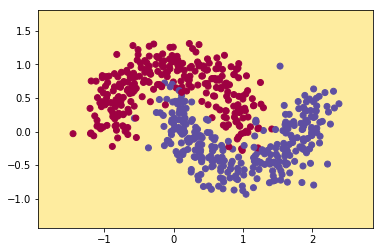

epoch is 0, train error 0.513333, test error 0.460000
epoch is 1, train error 0.513333, test error 0.165000
epoch is 2, train error 0.248333, test error 0.160000
epoch is 3, train error 0.201667, test error 0.175000
epoch is 4, train error 0.215000, test error 0.185000
epoch is 5, train error 0.206667, test error 0.185000
epoch is 6, train error 0.200000, test error 0.185000
epoch is 7, train error 0.200000, test error 0.185000
epoch is 8, train error 0.201667, test error 0.190000
epoch is 9, train error 0.203333, test error 0.190000
epoch is 10, train error 0.198333, test error 0.195000
epoch is 11, train error 0.198333, test error 0.195000
epoch is 12, train error 0.201667, test error 0.195000
epoch is 13, train error 0.201667, test error 0.195000
epoch is 14, train error 0.198333, test error 0.190000
epoch is 15, train error 0.198333, test error 0.190000
epoch is 16, train error 0.198333, test error 0.190000
epoch is 17, train error 0.195000, test error 0.190000
epoch is 18, train e

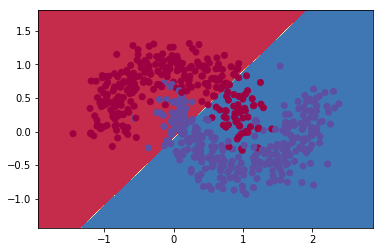

epoch is 25, train error 0.191667, test error 0.175000
epoch is 26, train error 0.193333, test error 0.170000
epoch is 27, train error 0.193333, test error 0.170000
epoch is 28, train error 0.191667, test error 0.165000
epoch is 29, train error 0.191667, test error 0.165000
epoch is 30, train error 0.193333, test error 0.160000
epoch is 31, train error 0.193333, test error 0.160000
epoch is 32, train error 0.193333, test error 0.160000
epoch is 33, train error 0.193333, test error 0.160000
epoch is 34, train error 0.193333, test error 0.160000
epoch is 35, train error 0.193333, test error 0.160000
epoch is 36, train error 0.193333, test error 0.160000
epoch is 37, train error 0.195000, test error 0.160000
epoch is 38, train error 0.195000, test error 0.160000
epoch is 39, train error 0.195000, test error 0.155000
epoch is 40, train error 0.195000, test error 0.155000
epoch is 41, train error 0.195000, test error 0.155000
epoch is 42, train error 0.193333, test error 0.155000
epoch is 4

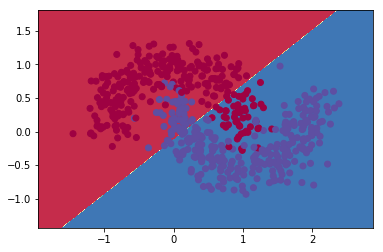

epoch is 50, train error 0.185000, test error 0.165000
epoch is 51, train error 0.185000, test error 0.160000
epoch is 52, train error 0.190000, test error 0.155000
epoch is 53, train error 0.188333, test error 0.155000
epoch is 54, train error 0.190000, test error 0.155000
epoch is 55, train error 0.190000, test error 0.155000
epoch is 56, train error 0.191667, test error 0.160000
epoch is 57, train error 0.190000, test error 0.160000
epoch is 58, train error 0.191667, test error 0.155000
epoch is 59, train error 0.191667, test error 0.160000
epoch is 60, train error 0.191667, test error 0.160000
epoch is 61, train error 0.190000, test error 0.155000
epoch is 62, train error 0.188333, test error 0.155000
epoch is 63, train error 0.188333, test error 0.155000
epoch is 64, train error 0.188333, test error 0.155000
epoch is 65, train error 0.188333, test error 0.155000
epoch is 66, train error 0.188333, test error 0.155000
epoch is 67, train error 0.188333, test error 0.155000
epoch is 6

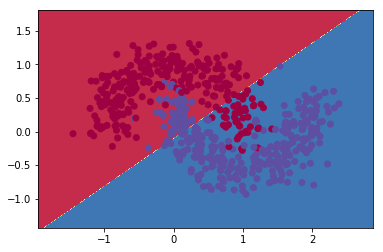

epoch is 75, train error 0.181667, test error 0.155000
epoch is 76, train error 0.183333, test error 0.145000
epoch is 77, train error 0.183333, test error 0.145000
epoch is 78, train error 0.185000, test error 0.150000
epoch is 79, train error 0.185000, test error 0.150000
epoch is 80, train error 0.183333, test error 0.150000
epoch is 81, train error 0.183333, test error 0.150000
epoch is 82, train error 0.183333, test error 0.150000
epoch is 83, train error 0.181667, test error 0.150000
epoch is 84, train error 0.181667, test error 0.150000
epoch is 85, train error 0.181667, test error 0.150000
epoch is 86, train error 0.181667, test error 0.150000
epoch is 87, train error 0.180000, test error 0.150000
epoch is 88, train error 0.180000, test error 0.150000
epoch is 89, train error 0.180000, test error 0.150000
epoch is 90, train error 0.180000, test error 0.150000
epoch is 91, train error 0.178333, test error 0.150000
epoch is 92, train error 0.178333, test error 0.150000
epoch is 9

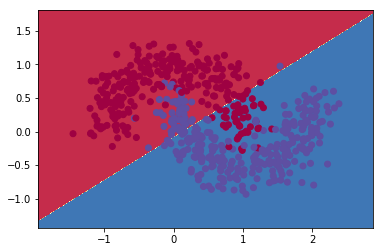

In [6]:
import pickle

if __name__=="__main__":
    data = load_data('moons', load_directly=True)
    sgd_optimization(data, learning_rate=0.1, n_epochs=100, draw_freq=25)

### Course Testing

In [ ]:
a, b = [1,2]
a, b

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import tensorflow as tf

### Hello World

In [ ]:
# Step 1: placeholder
x = tf.placeholder(tf.float32, [None, 2], name='x')
y = tf.placeholder(tf.float32, [None, 2], name='y')

# Step 2: network
output = x * y

# Step 3: prepare data
data_x = np.random.rand(8).reshape([4,2])
data_y = np.arange(8).reshape([4,2]).astype(np.int32)

# Step 4: run
with tf.Session() as sess:
    output = sess.run(
        [output],
        feed_dict = {x: data_x, y: data_y}
    )
    print(output)

In [ ]:
import tensorflow as tf
a = tf.eye(3 ,name='a')
b = tf.ones(3, name='b')
c = tf.zeros([5,2,4,3], dtype=tf.int32, name='c')
d = tf.reshape(tf.range(60), [5,2,3,2], name='d')
e = tf.constant([1,2,3,4,5], name='e')
f = tf.matmul(c, d)
var = [a,b,c,d,e,f]

sess = tf.Session()
output = sess.run(
    var,
    # feed_dict = {x: np.ones(3)}
)

for k,v in zip(var, output):
    print(k)
    print(v)
    print()

sess.close()